In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from joblib import Parallel, delayed

from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX
from mgcpy.benchmarks.ts_benchmarks import IndependentAR1, CorrelatedAR1, NonlinearLag1

In [2]:
# Plotting univariate time series.

def plot_1d_ts(X, Y, title, xlab = "X_t", ylab = "Y_t"):
    n = X.shape[0]
    t = range(1, n + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
    fig.suptitle(title)
    plt.rcParams.update({'font.size': 15})

    ax1.plot(t, X)
    ax1.plot(t, Y)
    ax1.legend(['X_t', 'Y_t'], loc = 'upper left', prop={'size': 12})
    ax1.set_xlabel("t")

    ax2.scatter(X,Y, color="black")
    ax2.set_ylabel(ylab)
    ax2.set_xlabel(xlab)

# Power computation functions.

def power_curve(tests, process, num_sims, alpha, sample_size, verbose = False):
    """
    Method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param verbose: whether to display output.
    :type verbose: boolean

    :param sample_sizes: range of sample sizes for which to estimate power.
    :type sample_sizes: 1-D array-like
    """
    # Store simulate processes.
    n_full = sample_sizes[len(sample_sizes) - 1]
    X_full = np.zeros((n_full, num_sims))
    Y_full = np.zeros((n_full, num_sims))
    for s in range(num_sims):
        X_full[:, s], Y_full[:, s] = process.simulate(n_full)

    for test in tests:
        powers = np.zeros(len(sample_sizes))
        for i in range(len(sample_sizes)):
            n = sample_sizes[i]
            if verbose: print("Estimating power at sample size: %d" % n)
            powers[i] = _compute_power(test, X_full, Y_full, num_sims, alpha, n)
        test['powers'] = powers

    # Display.
    _plot_power(tests, sample_sizes, alpha, process)

def _compute_power(test, X_full, Y_full, num_sims, alpha, n):
    """
    Helper method estimate power of a test on a given simulation.

    :param test: Test to profile, either DCorrX or MGCX.
    :type test: TimeSeriesIndependenceTest

    :param X_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type X_full: 2D ``numpy.array``

    :param Y_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type Y_full: 2D ``numpy.array``

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param n: sample size.
    :type n: integer

    :return: returns the estimated power.
    :rtype: float
    """
    num_rejects = 0.0

    def worker(s):
        X = X_full[range(n), s]
        Y = Y_full[range(n), s]

        p_value, _ = test['object'].p_value(X, Y, is_fast = test['is_fast'], subsample_size = test['subsample_size'])
        if p_value <= alpha:
            return 1

        return 0

    num_rejects = np.sum(Parallel(n_jobs=-2, verbose=10)(delayed(worker)(s) for s in range(num_sims)))

    return num_rejects / num_sims

def _plot_power(tests, sample_sizes, alpha, process):
    """
    Helper method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param sample_sizes: range of sample sizes for which to estimate power.
    :type sample_sizes: 1-D array-like

    :param alpha: significance level.
    :type alpha: float

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess
    """
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots()
    plt.title(process.name)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    plt.ylim((-0.05, 1.05))

    for test in tests:
        plt.plot(sample_sizes, test['powers'], linestyle = '-', color = test['color'])
    ax.legend([test['name'] for test in tests], loc = 'upper left', prop={'size': 12})

    ax.axhline(y = alpha, color = 'black', linestyle = '--')
    plt.show()

Simple test that everything works.

In [3]:
n = 100
X = np.random.normal(0.0, 1.0, n).reshape(n,1)
Y = np.random.normal(0.0, 1.0, n).reshape(n,1)

max_lag = 0

dcorrx = DCorrX(max_lag = max_lag)
p_value, dcorrx_metadata = dcorrx.p_value(X, Y, is_fast = True)
print("The p_value for DCorrX is: %f" % p_value)

mgcx = MGCX(max_lag = max_lag)
p_value, mgcx_metadata = mgcx.p_value(X, Y, is_fast = True)
print("The p_value for MGCX is: %f" % p_value)

The p_value for DCorrX is: 1.000000
The p_value for MGCX is: 1.000000


(array([8., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.        , 0.01686084, 0.03372168, 0.05058252, 0.06744336,
        0.08430419, 0.10116503, 0.11802587, 0.13488671, 0.15174755,
        0.16860839]),
 <a list of 10 Patch objects>)

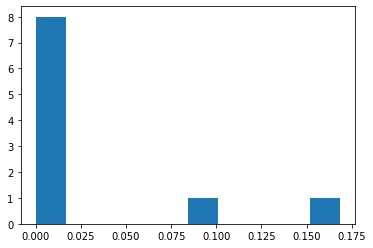

In [4]:
null_dist = mgcx_metadata['null_distribution']
plt.hist(null_dist)

Experiments.

In [5]:
max_lag = 1
num_sims = 35
alpha = 0.05

dcorrx = DCorrX(max_lag = max_lag)
mgcx = MGCX(max_lag = max_lag)

tests = [
#     {
#         'name' : 'DCorr-X',
#         'filename' : 'dcorrx',
#         'is_fast' : False,
#         'subsample_size' : -1,
#         'object' : dcorrx,
#         'color' : 'red',
#     },
    {
        'name' : 'Fast DCorr-X',
        'filename' : 'fast_dcorrx',
        'is_fast' : True,
        'subsample_size' : 10,
        'object' : dcorrx,
        'color' : 'blue',
    },
#     {
#         'name' : 'MGC-X',
#         'filename' : 'mgcx',
#         'is_fast' : False,
#         'object' : mgcx,
#         'color' : 'orange',
#     },
#     {
#         'name' : 'Fast MGC-X',
#         'filename' : 'fast_mgcx',
#         'is_fast' : True,
#         'subsample_size' : 10,
#         'object' : mgcx,
#         'color' : 'green',
#     },
]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1152s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  14 out of  35 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done  18 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done  22 out of  35 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  26 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:    0.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1228s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  14 out of 

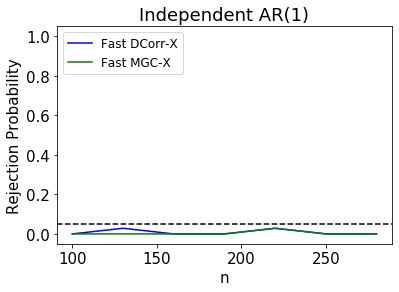

In [6]:
sample_sizes = range(100, 300, 30)
process = IndependentAR1()
power_curve(tests, process, num_sims, alpha, sample_sizes)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1138s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  14 out of  35 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done  18 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done  22 out of  35 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  26 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:    0.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1240s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  14 out of 

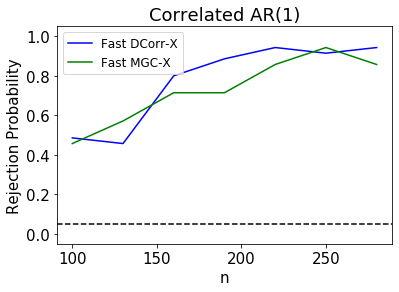

In [7]:
sample_sizes = range(100, 300, 30)
process = CorrelatedAR1()
power_curve(tests, process, num_sims, alpha, sample_sizes)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1141s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  14 out of  35 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done  18 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done  22 out of  35 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  26 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:    0.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1214s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  14 out of 

[Parallel(n_jobs=-2)]: Done  30 out of  35 | elapsed:   16.0s remaining:    2.7s
[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:   16.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-2)]: Done  26 out of  35 | elapsed:   16.3s remaining:    5.7s
[Parallel(n_jobs=-2)]: Done  30 out of  35 | elapsed:   20.3s remaining:    3.4s
[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:   20.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-2)]: Done  26 out of  35 | elapsed:   21.3s remaining:    7.4s
[Parallel(

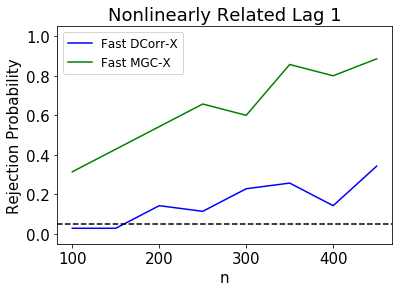

In [9]:
sample_sizes = range(100, 500, 50)
process = NonlinearLag1()
power_curve(tests, process, num_sims, alpha, sample_sizes)